In [3]:
import time

from google_api import generate
from llama_api import generate_llama

In [4]:
import random


def create_prompt(coherence, number_of_dots, direction,
                  preamble=None, appendix=None):
    prompt = ''
    if preamble is None:
        preamble = 'In this task you see dots moving. Please indicate the main direction of the dots. You can only look at one point at a time. You look at some of the dots one after each other. Here is how they move:'
    if appendix is None:
        appendix = 'Please indicate the main direction of the dots. Please respond left or right and nothing else. Your response should be in the form of a single word. Either "left" or "right".'
    prompt += preamble
    if abs(coherence * number_of_dots  - round(coherence * number_of_dots)) > 0.004:
        raise ValueError('coherence * number_of_dots must be an integer')
    if direction == 'right':
        trials = ['This dot is moving right.'] * int(number_of_dots * coherence)
        trials += ['This dot is moving left.'] * int(number_of_dots * (1-coherence))
    else:
        trials = ['This dot is moving left.'] * int(number_of_dots * coherence)
        trials += ['This dot is moving right.'] * int(number_of_dots * (1-coherence))
    random.shuffle(trials)
    for trial in trials:
        prompt += ' ' + trial
    prompt += ' ' + appendix
    return prompt

In [5]:
create_prompt(.5, 5, 'left')

ValueError: coherence * number_of_dots must be an integer

In [6]:
def get_accuracy(response, direction):
    return response.lower() in direction or direction in response.lower()

In [7]:
p, _ = create_prompt(.55, 100, 'right')
generate(p)

ValueError: too many values to unpack (expected 2)

In [8]:
# coherences = [.5, .51, .52, .53, .54, .55, .56, .57, .58, .59, .6,.62,.64, .65,.68,.7,.72,.74,.76, .8, .9,1.]
coherences =[.5, .51,.52,.54, .58, .6,.61,.62,.63,.64, .65,.66, .67,.7, .8, .9, 1.]
coherences = [.5, .51,.52, .53, .54, .55,.56,.57,.58,.59,
              .6, .61,.62, .63, .64, .65,.66,.67,.68,.69,
              .7, .71,.72, .73, .74, .75,.76,.77,.78,.79,
              .8, .81,.82, .83, .84, .85,.86,.87,.88,.89,
              .9, .91,.92, .93, .94, .95,.96,.97,.98,.99, 1.]
directions = ['left', 'right']
num_of_dots = 100
num_trials = 100

In [16]:
import time
import json
with open('psychometric.json', 'r') as f:
    data = json.load(f)
    
is_sleep = False
# model = 'llama3.1-70b'
# model = 'mixtral-8x22b'
# model = 'llama2-7b'
models = ['llama3.1-70b', 'llama2-7b', 'llama3-8b', 'gemini-1.5-flash-002', 'gemini-1.0-pro-001']
models = ['llama3.1-70b', 'gemini-1.5-flash-002', 'gemini-1.0-pro-001']
models = ['llama3.1-70b']
models = ['llama3-8b']

# model = 'llama3-8b'
i = 0
for _ in range(num_trials):
    for direction in directions:   
        for coherence in coherences:
            prompt= create_prompt(coherence, num_of_dots, direction)
            model = random.choice(models)
            if 'gemini' in model:
                response = generate(prompt)
            else:
                response = generate_llama(prompt, model)
            accuracy = get_accuracy(response, direction)
            if is_sleep:
                time.sleep(4)
            data['coherence'].append(coherence)
            data['direction'].append(direction)
            data['num_of_dots'].append(num_of_dots)
            data['prompt'].append(prompt)
            data['response'].append(response)
            data['accuracy'].append(accuracy)
            data['model'].append(model)
            print('.', end='')
            i+=1
            if not i % len(coherences):
                print('')
            with open('psychometric.json', 'w') as f:
                json.dump(data, f)

...................................................
.

KeyboardInterrupt: 

[0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.65 0.7  0.8
 0.9  1.   0.62 0.63 0.64 0.66 0.67 0.68 0.69 0.61 0.75 0.72 0.74 0.76]


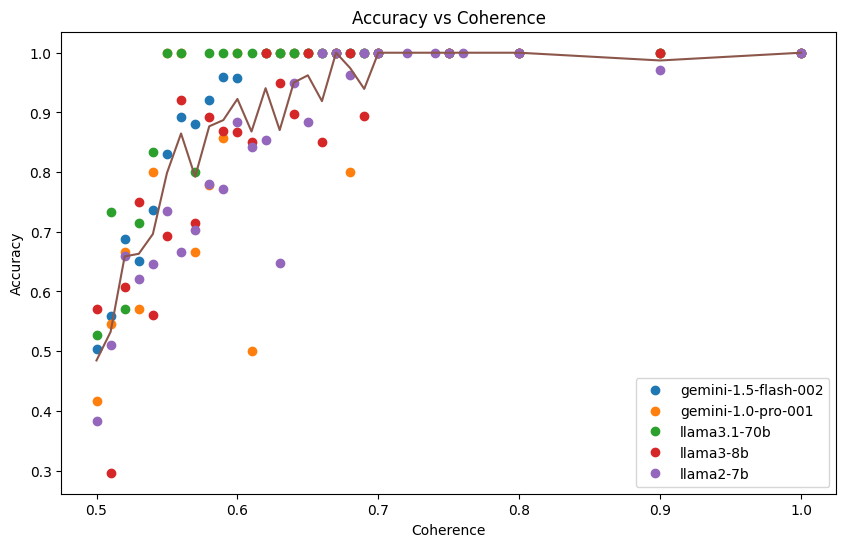

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
with open('psychometric.json', 'r') as f:
    data = json.load(f)
    
    
df = pd.DataFrame(data)
print(df['coherence'].unique())
# remove all rows where coherenc is above 1 or below 0
df = df[df['coherence'] <= 1]
df = df[df['model'] != 'llama3-8']

# use get_accuracy to get the accuracy in each row 
df['accuracy_new'] = df.apply(lambda x: get_accuracy(x['response'], x['direction']), axis=1)
df.to_csv('psychometric.csv')

df = df[df['num_of_dots'] == 100]


# plot the data mean coherence vs mean accuracy with model as hue
plt.figure(figsize=(10, 6))


for m in df['model'].unique():
    plt.plot(df[df['model'] == m].groupby('coherence')['coherence'].mean(), df[df['model'] == m].groupby('coherence')['accuracy_new'].mean(), 'o')
plt.errorbar(df.groupby('coherence')['coherence'].mean(), df.groupby('coherence')['accuracy_new'].mean())


# plot the full average
plt.xlabel('Coherence')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Coherence')
plt.legend(df['model'].unique())
plt.show()



# plot the data points

# plt.plot(df.groupby('coherence')['accuracy'].mean())

plt.show()


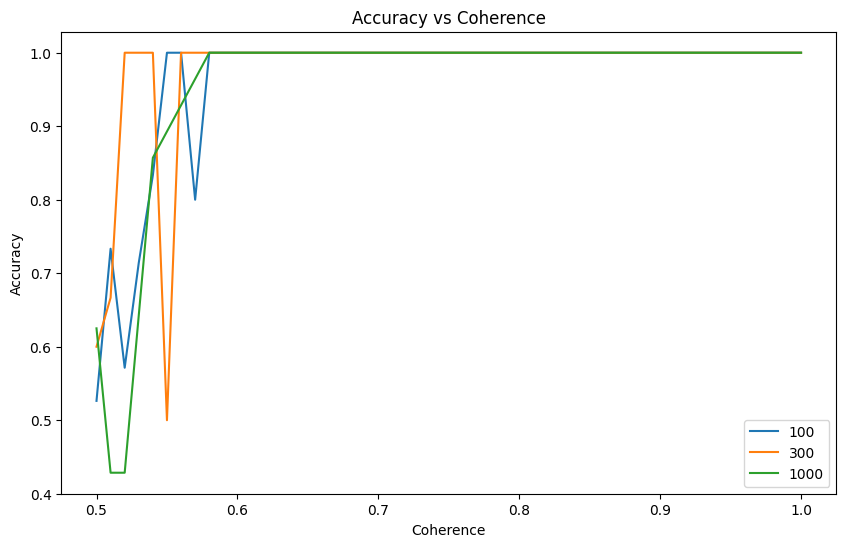

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
with open('psychometric_bu.json', 'r') as f:
    data = json.load(f)

models_excluded = ['llama3-8b', 'llama2-7b']
    
df = pd.DataFrame(data)

# remove all rows where coherenc is above 1 or below 0
df = df[df['coherence'] <= 1]
df.to_csv('psychometric.csv')
for m in models_excluded:
    df = df[df['model'] != m]
df = df[df['model'] == 'llama3.1-70b']


# use get_accuracy to get the accuracy in each row 
df['accuracy_new'] = df.apply(lambda x: get_accuracy(x['response'], x['direction']), axis=1)


# plot the data mean coherence vs mean accuracy with model as hue
plt.figure(figsize=(10, 6))
# plot average for each model smooth the curve
# for m in df['model'].unique():
#     model_data = df[df['model'] == m].groupby('coherence').mean().rolling(window=3).mean()
#     plt.plot(model_data['coherence'], model_data['accuracy'])


for n_d in df['num_of_dots'].unique():
    plt.errorbar(df[df['num_of_dots'] == n_d].groupby('coherence')['coherence'].mean(), df[df['num_of_dots'] == n_d].groupby('coherence')['accuracy_new'].mean())


# for m in df['model'].unique():
#     coherence_counts = df[df['model'] == m].groupby('coherence').size()
# 
# # Normalize the counts to get alpha values (between 0.1 and 1)
#     min_count = coherence_counts.min()
#     max_count = coherence_counts.max()
#     normalized_counts = (coherence_counts - min_count) / (max_count - min_count)
#     alphas = 0.1 + 0.9 * normalized_counts
# 
# # Plot the data with varying alpha values
#     for coherence, alpha in alphas.items():
#         subset = df[(df['model'] == m) & (df['coherence'] == coherence)]
#         plt.plot(subset['coherence'].mean(), subset['accuracy'].mean(), 'o', alpha=alpha)

# plot the full average
plt.xlabel('Coherence')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Coherence')
plt.legend(df['num_of_dots'].unique())
plt.show()



# plot the data points

# plt.plot(df.groupby('coherence')['accuracy'].mean())

plt.show()


In [20]:
df = pd.read_csv('psychometric_2.csv')
df = df.drop(columns='Unnamed: 0')
dct = df.to_dict(orient='list')
with open('psychometric.json', 'w') as f:
    json.dump(dct, f)